In [10]:
from sbi.neural_nets import posterior_nn
from sbi.inference import NLE, DirectPosterior
#from sbi.diagnostics import SBC
import torch
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from sbi.analysis import pairplot


**SBI**

In [11]:
def simulate(parameters):
    x = torch.linspace(0, 10, 500) 
    sigma = 0.3
    seed = 42
    a = parameters[0]
    b = parameters[1]
    noise = torch.normal(mean=0.0, std=sigma, size=(len(x),))
    y = a * x + b + noise
    return torch.tensor(y, dtype=torch.float32)

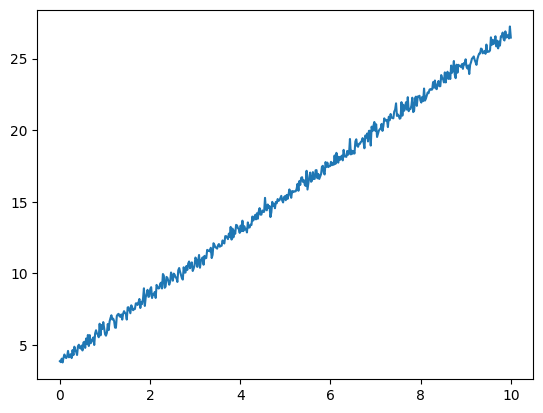

In [12]:
y_obs = simulate([2.3,3.9])
x = torch.linspace(0, 10, 500) 

plt.plot(x, y_obs)

In [13]:
from sbi.utils import BoxUniform
num_dim = 2
prior = BoxUniform(low=-5 * torch.ones(num_dim), high=5 * torch.ones(num_dim))

In [14]:
num_simulations = 1000
theta = prior.sample((num_simulations,))
y_simulations = torch.stack([simulate(th) for th in theta])


In [15]:
inference = NLE(prior=prior)


In [16]:
likelihood_net = inference.append_simulations(theta, y_simulations).train()


 Neural network successfully converged after 545 epochs.

In [17]:
posterior = inference.build_posterior()
posterior_theta = posterior.sample((15000,), x=y_obs)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >],
        [<Axes: xlabel='dim 1'>, <Axes: xlabel='dim 2'>]], dtype=object))

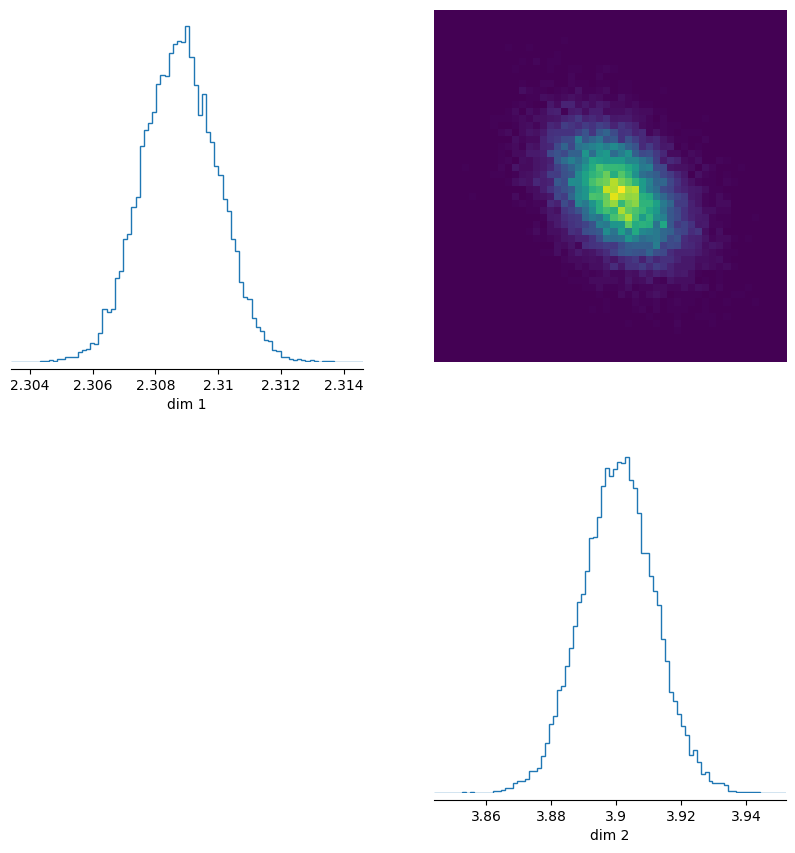

In [18]:
pairplot(posterior_theta)

**Simulation-based calibration test**

In [49]:
from sbi.diagnostics import run_sbc

# Define a summary statistic function (here we use the full simulated vector)
def summarize_simulation(y):
    # Could also return means, variances, etc. depending on needs
    return y

# Number of SBC runs
num_sbc_samples = 100  # you can increase to ~200 for more robust checks

# Draw prior samples
prior_samples = prior.sample((num_sbc_samples,))

# Simulate data for each prior sample
prior_predictives = torch.stack([simulate(theta) for theta in prior_samples])

# Compute summary statistics for SBC
prior_predictive_summary_stats = torch.stack([summarize_simulation(y) for y in prior_predictives])

# Number of posterior samples to draw per SBC iteration
num_posterior_samples = 1000

# Run SBC
ranks, dap_samples = run_sbc(
    prior_samples,
    prior_predictive_summary_stats,
    posterior,
    reduce_fns=lambda theta, x: -posterior.log_prob(theta, x),
    num_posterior_samples=num_posterior_samples,
    use_batched_sampling=False  # safe for memory, slower
)

# Plot SBC results
fig, ax = sbc_rank_plot(
    ranks,
    num_posterior_samples,
    plot_type="cdf",
    num_bins=20,
    figsize=(6, 4)
)

Sampling 100 times (1000,) posterior samples.: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [22:21<00:00, 13.42s/it]


Calculating ranks for 100 SBC samples:   0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'sbc_rank_plot' is not defined

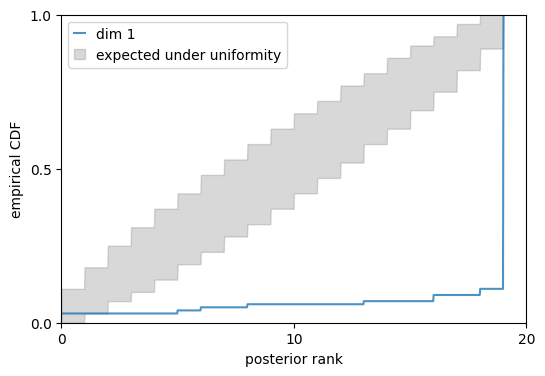

In [50]:
from sbi.analysis.plot import sbc_rank_plot
# Plot SBC results
fig, ax = sbc_rank_plot(
    ranks,
    num_posterior_samples,
    plot_type="cdf",
    num_bins=20,
    figsize=(6, 4)
)

**Nautilus sampler**

In [21]:
from sbi.inference import likelihood_estimator_based_potential

In [25]:
from nautilus import Prior
from nautilus import Sampler


In [26]:
prior_nautilus = Prior()
prior_nautilus.add_parameter('a', dist=(-5, +5))
prior_nautilus.add_parameter('b', dist=(-5, +5))


In [27]:
potential_fn, _ = likelihood_estimator_based_potential(likelihood_net, prior, y_obs, enable_transform=False)

In [39]:
def log_likelihood_nautilus(param_dict):
    """
    Likelihood function for Nautilus using SBI-trained likelihood estimator.
    
    The key insight is that SBI's likelihood estimator is p(x|theta), so we need:
    - x: the observed data (y_obs)  
    - theta: the parameters we're evaluating
    """
    # Extract parameters
    numpy_theta = np.array([param_dict[key] for key in ['a','b']])
    
    # Create parameter tensor
    theta = torch.tensor(numpy_theta, dtype=torch.float32)
    
    if len(theta.shape) == 1:
        theta = theta.unsqueeze(0)
        
    return potential_fn(theta).detach().numpy().flatten()[0]
    

In [40]:
sampler = Sampler(prior_nautilus, log_likelihood_nautilus, n_live=1000)
sampler.run(verbose=True)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 26     | 1        | 4        | 30700    | N/A    | 10074 | +518.25  


np.True_

In [41]:
log_z_likelihood = sampler.log_z
print(log_z_likelihood)

518.2549664630285


In [51]:
import corner
import matplotlib.pyplot as plt

points, log_w, log_l = sampler.posterior()
corner.corner(
    points, weights=np.exp(log_w), bins=20, labels=prior.keys, color='purple',
    plot_datapoints=False, range=np.repeat(0.999, len(prior.keys)))

ModuleNotFoundError: No module named 'corner'